In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sb

In [73]:
class BagOfFunction(object):
    
    def __init__(self):
        pass

    def log_earning(series):
        """
        функция возвращает лог.доходность
        series = np.array()
        """
        return np.log(series[1:]/series[:-1])
    

    def get_stats(self, series, n_round=3, quant=0.05):
        """
        return list(min, median, max, 95$CI, quantile) for series
        n_round = число разрядов для акругления

        """
        min_ = round(np.min(series), n_round)
        median_ = round(np.median(series), n_round)
        max_ = round(np.max(series), n_round)
        CI = tuple([round(np.quantile(series, 0.025),3), round(np.quantile(series, 0.975), 3)])
        quant_ = round(np.quantile(series, quant), n_round)

        return [min_, median_, max_, CI, quant_, quant]
    

    def print_stats(self, result, title):
        """
        функция для вывода резульататов от get_stats()
        """
        print('{title}: \
        \n \n \
        min = {min_} \n \
        median = {median_} \n \
        max = {max_} \n \
        95%CI = {CI} \n \
        quantile {quant_n}% = {quant}'.format(min_=result[0], 
                                              max_=result[2], 
                                              median_=result[1], 
                                              CI=result[3], 
                                              quant=result[4], 
                                              quant_n=result[5]*100, 
                                              title=title))

    def mult(self, array):
        """
        функция перемножает аррей
        """
        result = 1
        for i in array:
            result*=i
        return result
    
    def walking(self, start, road_map):
        """
        функция реализует случайное блуждание, каждый следующий шаг прибавляет дельту к предыдущему,
        дельта берется из road_map - список дельт
        """
        price_series = [start]
        for i in range(1, len(road_map)):
            price_series.append(price_series[i-1]+price_series[i-1]*road_map[i-1])
        return np.array(price_series)

class NPVmodel(object):
    
    def __init__(self): 
        self.npv_list = list() #склад оценок NPV
        self.mu_dinamic = list() #склад динамики изменения мат.ожидания NPV
        self.alpha_dinamic = list() #склад генераций процентной ставки alpha
        self.delay_dinamic = list() #склад генераций задержек платежей
        self.cf_dinamic = list() #склад генераций размеров платежей
        self.bof = BagOfFunction() #подключаем внешний класс с полезными функциями

    def delay_discountin(self, delay, alpha, df_list):
        """
        метод дополнительного дисконтирования платежей в результате задержки
        
        alpha: list,
        список ключевых ставок
        
        delay: list
        время задержки платежа, len = числу платежей
        
        df_list: list
        дефолтные параметры дисконтирования, len = числу платежей
        """

        n = self.n
        discount_list = list()
        bof = self.bof
        for i, x in enumerate(delay):
            if x > 0:
                add_discount = list()
                first_step = 1 # детектор первого шага цикла
                for j in range(math.ceil(x)-1, -1, -1):
                    if (i+j) <= len(alpha):
                        if first_step and x > math.floor(x): #на первом шаге нам нужно учесть только кусочек пути, если там есть таковой
                            add_discount.append((1/(1+alpha[i+j-1]))**(x-math.floor(x))) #дополнительное дисконтирование отложенного платежа
                            first_step = 0
                        else:
                            if first_step and x > math.floor(x):
                                add_discount.append((1/(1+alpha[i+j-1]))**(x-math.floor(x))) #дополнительное дисконтирование отложенного платежа
                                first_step = 0
                            else:
                                add_discount.append((1/(1+alpha[i+j-1])))
                    else:
                        add_discount.append((1/(1+alpha[len(alpha)-1]))) #если период превысил границу, то продолжаем его дисконировать
                discount = df_list[i]*bof.mult(add_discount)             #перемножаем всем дисконты текущего периода
                discount_list.append(discount)
            else: #оставляем без изменений
                discount_list.append(df_list[i])

        return np.array(discount_list)

    def calc_discount_param(self, start_alpha):
        """
        функция возвращает вектор дисконтирования для n периодов
        n - float, число периодов
        alpha - float или np.ndarray, процентная ставка
        delay - учитываем задержку
        """
        n = self.n
        alpha = start_alpha
        delay_lambd = self.delay_lambd
        
        df_list = [1] # первый DF всегда равен 1 далее от него начнем генерацию
        if type(alpha) == float:
            for i in range(1, n):
                df_list.append(df_list[i-1]/(1+alpha))
        elif type(alpha) == np.ndarray:
            assert len(alpha) == n, 'Список alpha должн равняться числу генерируемых DF'
            for i in range(1, n):
                df_list.append(df_list[i-1]/(1+alpha[i-1]))
        else:
            raise TypeError("alpha должен иметь формат float или numpy.ndarray")

        if delay_lambd is not None: #дополнительное дисконтирование для учета возможности несвоевременных платежей
            delay = np.random.exponential(scale=delay_lambd, size=n)
            self.delay_dinamic.append(delay)
            df_list = self.delay_discountin(delay, alpha, df_list)
        return np.array(df_list)

    def alpha_generation(self, start_alpha, a, b):
        """
        генерирует ключевую ставку, как случайную величину
        """
        n = self.n
        bof = self.bof
        delta = np.random.beta(a=1, b=1, size=n) #размер шага
        sign = np.sign(np.random.beta(a=a, b=b, size=n) - 0.5) #направление шага, если a>b - чаще идем ввех
                                                               #направление шага, если a=b - случайное блуждание
                                                               #направление шага, если a<b - чаще идём вниз
        if type(start_alpha)==np.ndarray: #если ключевая ставка предзадана по периодам используются эти значения
            return start_alpha+start_alpha*delta*sign
        
        if type(start_alpha)==float: # если задана только начальная точка, то реализуется случайное блуждание
            return bof.walking(start_alpha, delta*sign)


    def npv_estimation(self, cf, alpha_start, percent_var, n_iter = 5000, sigma=False, delay_lambd=None, alpha_gen=False, beta_param=[1, 1]):
        """
        функция возвращает лист оценочных значений NPV длинной в число итераций, а также итеративную динамику среднего значения

        alpha_start: float
        стартовая процентнтая ставка

        sigma: float or numpy.array 
        отклонение доходностей

        n_iter: int
        число итераций

        delay: True/False (default=False)
        возможность задержки платежей

        delay_lambd: float (default=1)
        среднее время задержки платежей

        alpha_gen: True/False (default=True)
        Монте-Карло оценка альфы

        beta_param - параметры альфа и бета для, если alpha_gen=True
        """
        self.n = len(cf)
        self.cf = cf
        self.percent_var = percent_var
        self.delay_lambd = delay_lambd
        self.n_iter = n_iter
        self.alpha = alpha_start
        self.beta_param = beta_param
        
        if not sigma:
            self.sigma = abs(cf*percent_var)

        for _ in range(self.n_iter):
            if alpha_gen:
                assert len(beta_param)==2, 'ожидается два параметра для beta распределения: a, b'
                alpha = self.alpha_generation(self.alpha, a=beta_param[0], b=beta_param[1])
                self.alpha_dinamic.append(alpha)
            else:
                alpha = self.alpha
                
            df_vector = self.calc_discount_param(alpha)
            cf_smpl = np.random.normal(self.cf, self.sigma)
            
            self.npv_list.append(sum(cf_smpl*df_vector))
            self.mu_dinamic.append(np.mean(self.npv_list))
            self.cf_dinamic.append(cf_smpl)
            
    def get_result(self):
        
        """
        функция выводит результаты в текстовом и графическом виде
        """
        npv_list = self.npv_list
        mu_dinamic = self.mu_dinamic
        alpha_dinamic = self.alpha_dinamic
        delay_dinamic = self.delay_dinamic
        cf_dinamic = self.cf_dinamic
        bof = self.bof

        fig, ax = plt.subplots(3, 2, figsize=(20, 30))

        ax[0][0].hist(npv_list, density=True, histtype='step', cumulative=1,
                label='Reversed emp.')
        ax[0][0].set_title('Empirical distribution function (Cumulative step histograms)', size = 17)
        ax[0][0].set_xlabel('Expected NPV', size = 15)
        ax[0][0].set_ylabel('Likelihood of occurrence', size = 15)
        ax[0][1].hist(npv_list)
        ax[0][1].set_title('Empirical distribution', size = 17)
        ax[0][1].set_xlabel('Expected NPV', size = 15)
        ax[0][1].set_ylabel('Count', size = 15)
        ax[1][0].plot(mu_dinamic[5:500])
        ax[1][0].set_title('mean(NPV) dynamic', size = 17)
        ax[1][0].set_xlabel('Number of Iteration', size = 15)
        ax[1][0].set_ylabel('mean(NPV)', size = 15)
        tmp_ex = ax[1][1]
        tmp_ex = sb.boxplot(data=pd.DataFrame(alpha_dinamic), ax=tmp_ex)
        tmp_ex.set_title('Симуляции колебаний ключевой ставки', size = 17)
        tmp_ex = ax[2][0]
        tmp_ex = sb.boxplot(data=pd.DataFrame(delay_dinamic), ax=tmp_ex)
        tmp_ex.set_title('Симуляция периодов неплатежа', size = 17)
        tmp_ex = ax[2][1]
        tmp_ex = sb.violinplot(data=pd.DataFrame(cf_dinamic).iloc[:,1:], ax=tmp_ex)
        tmp_ex.set_title('Симуляции размеров платежей', size = 17)

        print('Число итераций = ', self.n_iter)
        print('Начальная ставка = ', self.alpha)
        print('Платежи (cf) = ', ', '.join(map(str, self.cf)))
        print('Ожидаемое процентное колебание платежей = ', ', '.join(map(lambda x: x+'%', list(map(str, map(int, (self.percent_var*100)))))))
        print('Вариация (sigma) при оценке доходностей по периодам = ', ', '.join(map(str, self.sigma)))
        print('Сренее время задержки платежа = ', self.delay_lambd)
        print()
        print('Монте-Карло оценка ставки: sampling from Beta distribution with params: ', ', '.join(map(str, self.beta_param)))
        print('Монте-Карло оценка доходностей: sampling from Normal distribution with params: cf, sigma')
        print('Монте-Карло оценка дисконта при задержке платежей: sampling from Exponential distribution with params: ', self.delay_lambd)
        print()

        bof.print_stats(bof.get_stats(npv_list), title='Monte Carlo Value at NPV')


Число итераций =  10000
Начальная ставка =  0.05
Платежи (cf) =  -100, 25, 75, 23
Ожидаемое процентное колебание платежей =  0%, 10%, 20%, 30%
Вариация (sigma) при оценке доходностей по периодам =  0.0, 2.5, 15.0, 6.8999999999999995
Сренее время задержки платежа =  0.5

Монте-Карло оценка ставки: sampling from Beta distribution with params:  2, 1
Монте-Карло оценка доходностей: sampling from Normal distribution with params: cf, sigma
Монте-Карло оценка дисконта при задержке платежей: sampling from Exponential distribution with params:  0.5

Monte Carlo Value at NPV:         
 
         min = -45.283 
         median = 10.907 
         max = 76.494 
         95%CI = (-19.231, 41.702) 
         quantile 5.0% = -13.953


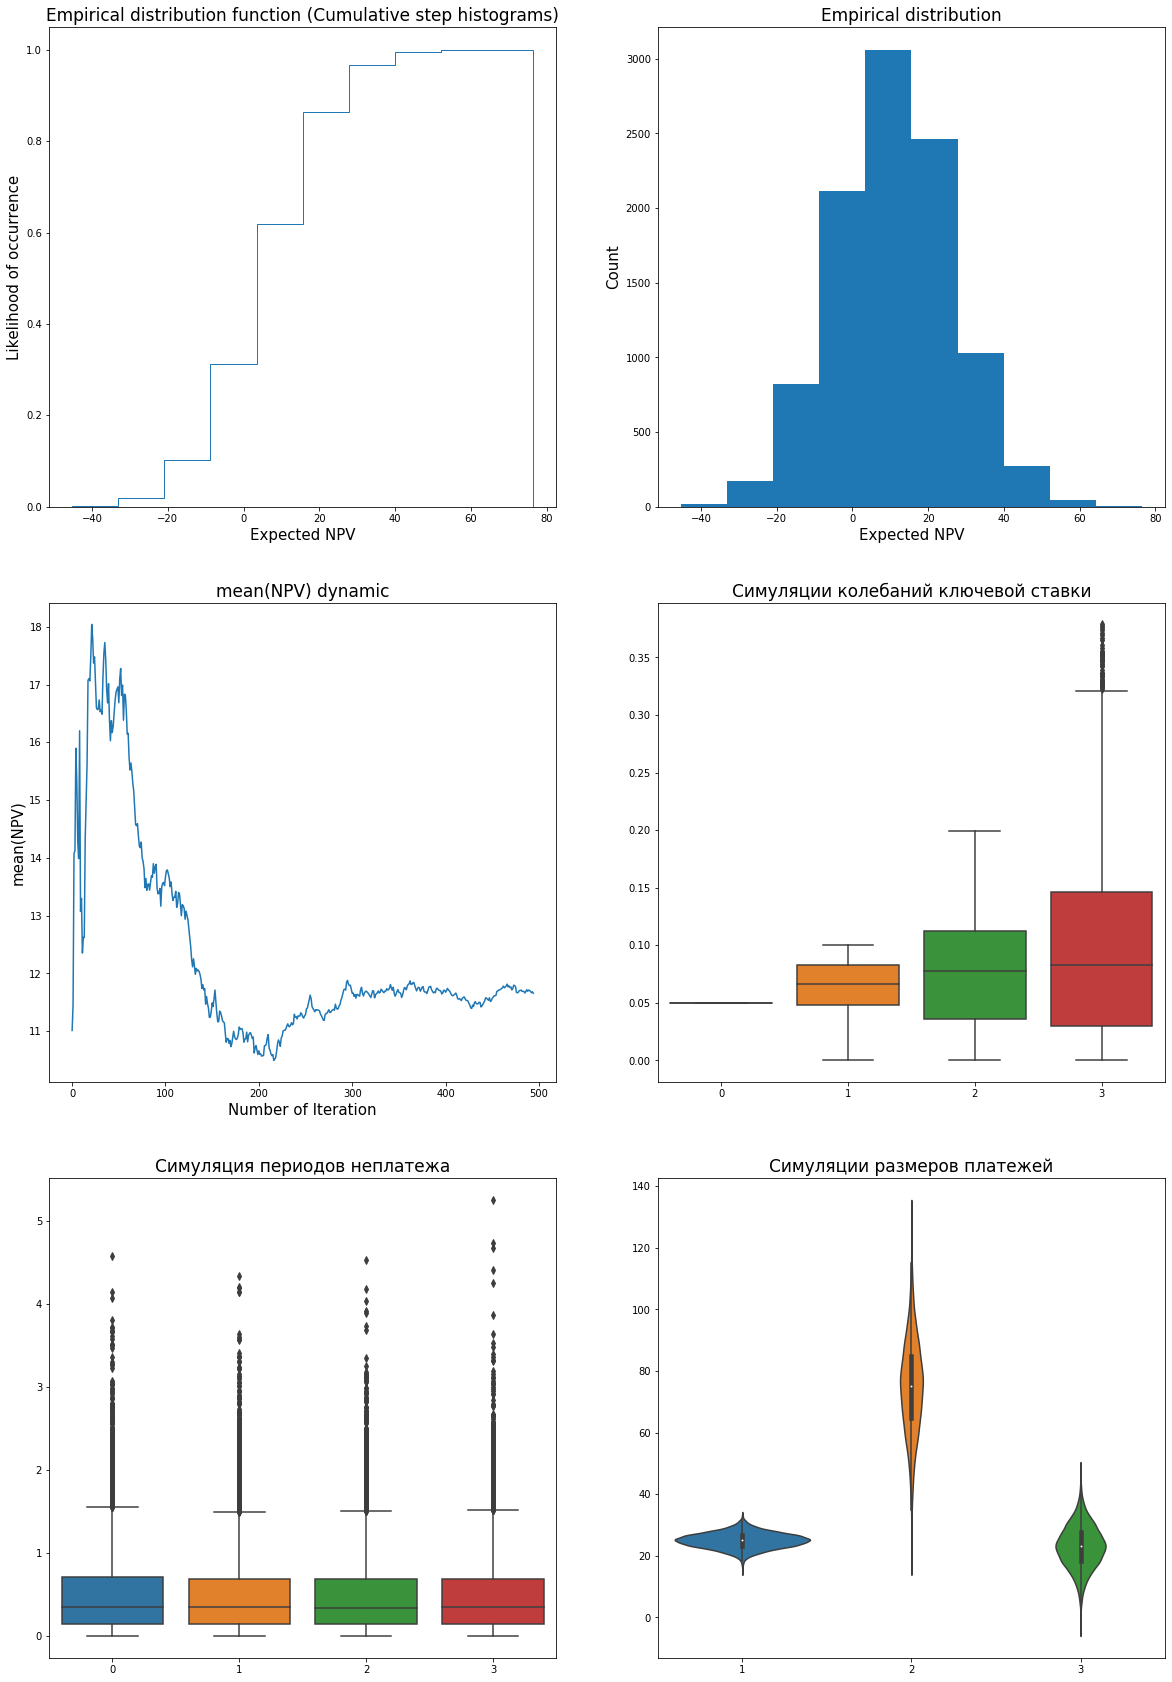

In [83]:
ITER = 10000
CF = np.array([-100, 25, 75, 23])
PERCENT_VAR = np.array([0, 0.1, 0.2, 0.3])
DELAY_LAMBD = 0.5
BETA_PARAM = [2, 1]
ALPHA = 0.05

npv_model = NPVmodel()
npv_model.npv_estimation(cf = CF, 
                         alpha_start = ALPHA,
                         percent_var = PERCENT_VAR, 
                         n_iter = ITER,
                         sigma=False, 
                         delay_lambd=DELAY_LAMBD, #средняя задержка платежа
                         alpha_gen=True, #Монте-Карло оценка ставки
                         beta_param=BETA_PARAM) #параметры Beta распределения для оценки ставки
npv_model.get_result()